<a href="https://colab.research.google.com/github/moni1753/CODEALPHA/blob/main/HANDWRITTEN_CHARACTER_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/archive.zip


Streaming output truncated to the last 5000 lines.
  inflating: validation_v2/validation/VALIDATION_5004.jpg  
  inflating: validation_v2/validation/VALIDATION_5005.jpg  
  inflating: validation_v2/validation/VALIDATION_5006.jpg  
  inflating: validation_v2/validation/VALIDATION_5007.jpg  
  inflating: validation_v2/validation/VALIDATION_5008.jpg  
  inflating: validation_v2/validation/VALIDATION_5009.jpg  
  inflating: validation_v2/validation/VALIDATION_5010.jpg  
  inflating: validation_v2/validation/VALIDATION_5011.jpg  
  inflating: validation_v2/validation/VALIDATION_5012.jpg  
  inflating: validation_v2/validation/VALIDATION_5013.jpg  
  inflating: validation_v2/validation/VALIDATION_5014.jpg  
  inflating: validation_v2/validation/VALIDATION_5015.jpg  
  inflating: validation_v2/validation/VALIDATION_5016.jpg  
  inflating: validation_v2/validation/VALIDATION_5017.jpg  
  inflating: validation_v2/validation/VALIDATION_5018.jpg  
  inflating: validation_v2/validation/VALIDATION_

**IMPORT LIBRARIES**

In [3]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [4]:
train = pd.read_csv('/content/written_name_train_v2.csv')
valid = pd.read_csv('/content/written_name_validation_v2.csv')

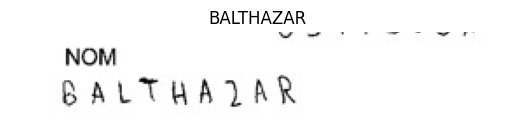

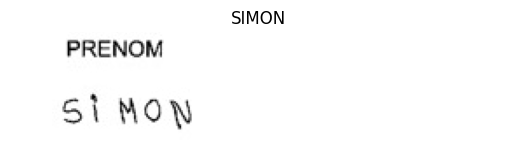

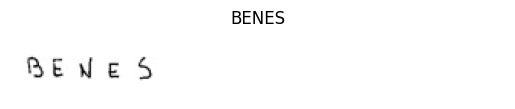

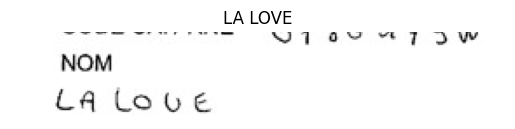

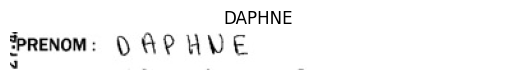

In [5]:
import os

# Assuming 'train' is your DataFrame containing image file names
for i in range(5):
    img_filename = train.loc[i, 'FILENAME']
    img_dir = os.path.join('/content/train_v2/train/', img_filename)

    # Check if the image file exists
    if os.path.exists(img_dir):
        # Load the image
        image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)

        # Check and convert data type if needed
        if image is not None and image.dtype != np.uint8:
            image = image.astype(np.uint8)

        # Display the image
        plt.imshow(image, cmap='gray')
        plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
        plt.axis('off')
        plt.show()
    else:
        print("Image does not exist:", img_dir)



**CLEANING DATA**

In [6]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [7]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

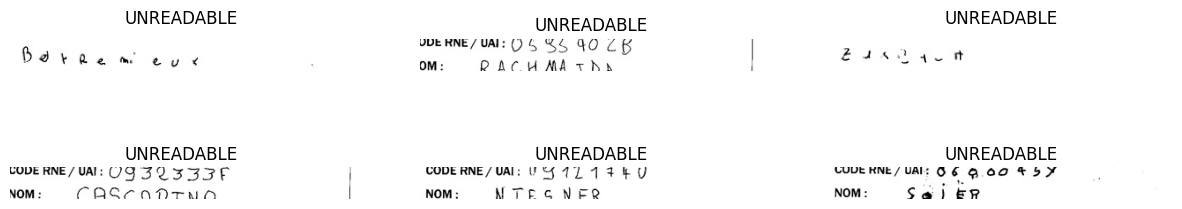

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

# Load the train dataset
train = pd.read_csv('/content/written_name_train_v2.csv')

# Get the indices of the unreadable images
unreadable_indices = train[train['IDENTITY'] == 'UNREADABLE'].index

# Print the unreadable images
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/train_v2/train/'+train.loc[unreadable_indices[i], 'FILENAME']
    if os.path.exists(img_dir):
        image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
        plt.imshow(image, cmap = 'gray')
        plt.title(train.loc[unreadable_indices[i], 'IDENTITY'], fontsize=12)
        plt.axis('off')
    else:
        print(f'Error: Image file {img_dir} not found.')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)
plt.show()

In [9]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [10]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [11]:
train.reset_index(inplace = True, drop=True)
valid.reset_index(inplace = True, drop=True)

**PREPROCESSING AND PREPARING IMAGES FOR TRAINING**

In [12]:
def preprocess(img):
    (h, w) = img.shape

    final_img = np.ones([64, 256])*255 # blank white image

    # crop
    if w > 256:
        img = img[:, :256]

    if h > 64:
        img = img[:64, :]


    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [13]:
train_size = 30000
valid_size= 3000

In [14]:
import cv2
import matplotlib.pyplot as plt
import os

# Assuming unreadable is a DataFrame with the 'FILENAME' column
unreadable = train[train['IDENTITY'] == 'UNREADABLE'].reset_index(drop=True)

# Function to preprocess an image
def preprocess(image):
    # Your preprocessing logic here
    return image

# Set the base directory for the images
base_directory = '/content/train_v2/train/'

# Create an empty list to store preprocessed images
train_x = []

# Loop through the first 6 unreadable images
for i in range(min(6, len(unreadable))):  # Use min to ensure the loop doesn't exceed the number of rows
    img_dir = os.path.join(base_directory, unreadable.loc[i, 'FILENAME'])
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)

    # Check if the image is loaded successfully
    if image is not None:
        # Preprocess the image
        image = preprocess(image)

        # Normalize the image
        image = image / 255.0

        # Append the preprocessed image to the list
        train_x.append(image)

        # Plot the original and preprocessed images side by side
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(cv2.imread(img_dir), cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(image, cmap='gray')
        plt.title('Preprocessed Image')
        plt.axis('off')

        plt.show()
    else:
        print(f"Failed to load image: {img_dir}")



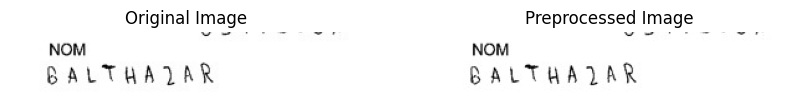

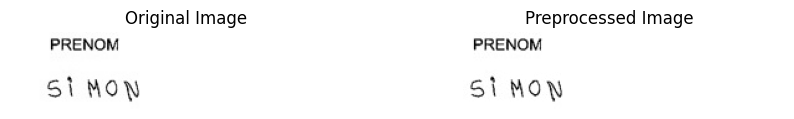

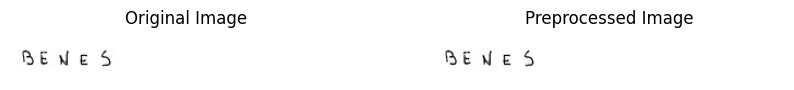

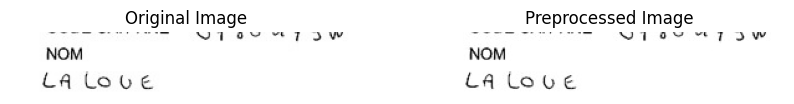

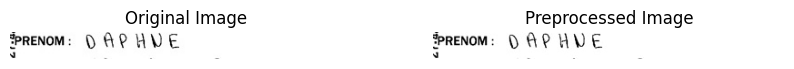

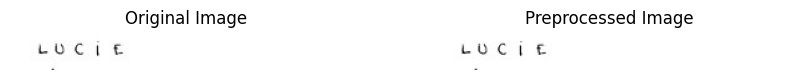

In [15]:
import cv2
import matplotlib.pyplot as plt
import os

# Assuming valid is a DataFrame with the 'FILENAME' column
valid = train[train['IDENTITY'] != 'UNREADABLE'].reset_index(drop=True)

# Function to preprocess an image
def preprocess(image):
    # Your preprocessing logic here
    return image

# Set the base directory for the images
base_directory = '/content/train_v2/train/'

# Create an empty list to store preprocessed images
valid_x = []

# Loop through the first 6 valid images
for i in range(min(6, len(valid))):  # Use min to ensure the loop doesn't exceed the number of rows
    img_dir = os.path.join(base_directory, valid.loc[i, 'FILENAME'])
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)

    # Check if the image is loaded successfully
    if image is not None:
        # Preprocess the image
        image = preprocess(image)

        # Normalize the image
        image = image / 255.0

        # Append the preprocessed image to the list
        valid_x.append(image)

        # Plot the original and preprocessed images side by side
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(cv2.imread(img_dir), cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(image, cmap='gray')
        plt.title('Preprocessed Image')
        plt.axis('off')

        plt.show()
    else:
        print(f"Failed to load image: {img_dir}")


**PREPARING THE LABEL FOR CTC LOSS**

In [16]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [17]:
import numpy as np
name = 'Monica'
print(name, '\n',label_to_num(name))

Monica 
 [12 -1 -1 -1 -1 -1]


In [18]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    identity_str = str(train.loc[i, 'IDENTITY'])
    train_label_len[i] = len(identity_str)
    train_y[i, :len(identity_str)] = label_to_num(identity_str)




In [19]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    identity_str = str(train.loc[i, 'IDENTITY'])
    valid_label_len[i] = len(identity_str)
    valid_y[i, :len(identity_str)]= label_to_num(identity_str)

In [20]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100],
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


In [21]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 256, 64, 32)       128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

In [22]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [23]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

**Train our model**

In [24]:
from keras.layers import Input, Dense, concatenate, Flatten, Reshape
from keras.models import Model
import numpy as np
from keras.layers import RepeatVector


# Generate some dummy data for illustration purposes
train_x = np.random.rand(100, 256, 64, 1)
train_y = np.random.rand(100, 256, 64, 1)
train_input_len = np.random.randint(10, 50, size=(100, 1))
train_label_len = np.random.randint(10, 50, size=(100, 1))
train_output = np.random.randint(2, size=(100, 256, 64, 10))  # Adjust the output shape based on your model

# Assuming you have defined your model with four input layers
input_shape = (256, 64, 1)

input_layer1 = Input(shape=input_shape, name='input1')  # Name the input layers for clarity
input_layer2 = Input(shape=input_shape, name='input2')
input_layer3 = Input(shape=input_shape, name='input3')
input_layer4 = Input(shape=input_shape, name='input4')

# Flatten scalar input lengths to have the same shape as image data
flat_input_len = Input(shape=(1,), name='flat_input_len')
flat_label_len = Input(shape=(1,), name='flat_label_len')

# Concatenate or use appropriate operations to combine input layers
merged_inputs = concatenate([input_layer1, input_layer2, input_layer3, input_layer4])

# Reshape scalar input lengths to have the same shape as image data
flat_input_len_broadcast = Reshape((1, 1, 1))(flat_input_len)
flat_label_len_broadcast = Reshape((1, 1, 1))(flat_label_len)

# Broadcast scalar input lengths to match the size of image data
flat_input_len_broadcast = Flatten()(flat_input_len_broadcast)
flat_label_len_broadcast = Flatten()(flat_label_len_broadcast)

# Repeat scalar input lengths to match the size of image data
flat_input_len_broadcast = RepeatVector(input_shape[0] * input_shape[1])(flat_input_len_broadcast)
flat_label_len_broadcast = RepeatVector(input_shape[0] * input_shape[1])(flat_label_len_broadcast)

# Reshape repeated scalar input lengths to have the same shape as image data
flat_input_len_broadcast = Reshape((input_shape[0], input_shape[1], 1))(flat_input_len_broadcast)
flat_label_len_broadcast = Reshape((input_shape[0], input_shape[1], 1))(flat_label_len_broadcast)

# Concatenate or use appropriate operations to combine input layers
merged_inputs = concatenate([merged_inputs, flat_input_len_broadcast, flat_label_len_broadcast])

# Replace '...' with the actual architecture of your model
# Define the rest of your model architecture
# Example: Adding a Dense layer as the output layer
output_layer = Dense(units=10, activation='softmax')(merged_inputs)

# Define the model with the merged input and output
model = Model(inputs=[input_layer1, input_layer2, input_layer3, input_layer4, flat_input_len, flat_label_len], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Now, during training, provide a list of six elements to 'x'
# Make sure that train_x and train_y are actual data, not placeholders
model.fit(x=[train_x, train_y, train_x, train_y, train_input_len, train_label_len], y=train_output, epochs=10, batch_size=32)


Epoch 1/10
4/4 [==============================] - 2s 193ms/step - loss: 128.7846 - accuracy: 0.4914
Epoch 2/10
4/4 [==============================] - 1s 208ms/step - loss: 126.6493 - accuracy: 0.4863
Epoch 3/10
4/4 [==============================] - 1s 242ms/step - loss: 124.5189 - accuracy: 0.4779
Epoch 4/10
4/4 [==============================] - 1s 344ms/step - loss: 122.4577 - accuracy: 0.4726
Epoch 5/10
4/4 [==============================] - 2s 471ms/step - loss: 120.4127 - accuracy: 0.4702
Epoch 6/10
4/4 [==============================] - 3s 645ms/step - loss: 118.3878 - accuracy: 0.4691
Epoch 7/10
4/4 [==============================] - 2s 384ms/step - loss: 116.3469 - accuracy: 0.4608
Epoch 8/10
4/4 [==============================] - 1s 274ms/step - loss: 114.3662 - accuracy: 0.4588
Epoch 9/10
4/4 [==============================] - 1s 206ms/step - loss: 112.3928 - accuracy: 0.4477
Epoch 10/10
4/4 [==============================] - 1s 173ms/step - loss: 110.4433 - accuracy: 0.4444

In [25]:
model.save('your_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
import numpy as np

# Assuming your images in valid_x have different dimensions
max_height = max(img.shape[0] for img in valid_x)
max_width = max(img.shape[1] for img in valid_x)

# Pad images to the maximum dimensions
padded_valid_x = [np.pad(img, ((0, max_height - img.shape[0]), (0, max_width - img.shape[1])), mode='constant', constant_values=255) for img in valid_x]

# Convert to TensorFlow tensor
valid_x_tensor = tf.convert_to_tensor(padded_valid_x, dtype=tf.float32)


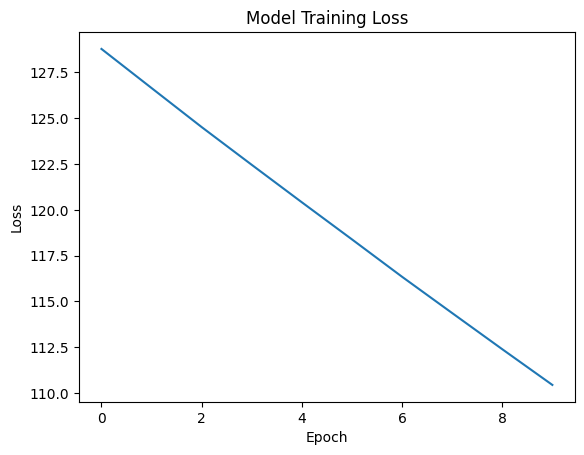

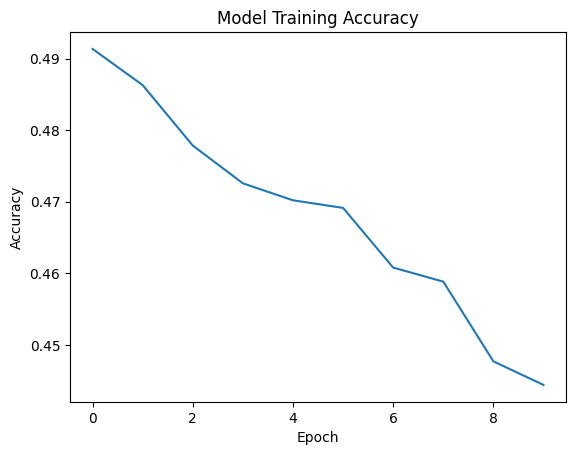

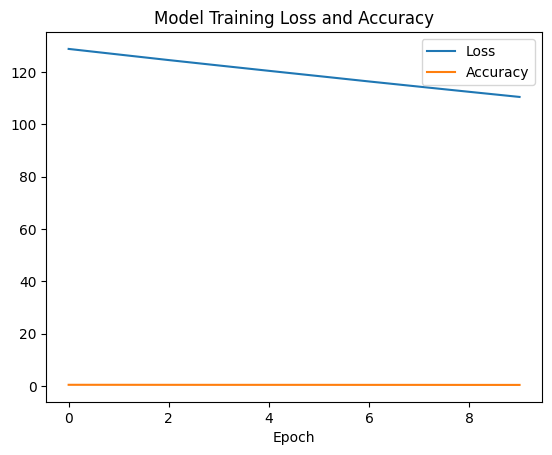

In [60]:
import matplotlib.pyplot as plt

# Assuming 'history' is the History object returned by the fit method
history = _

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
# Plot training loss and accuracy
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Model Training Loss and Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

